### Q1.2

#### K-Means

In [38]:
import numpy as np

def syn_data(sigma):

    x_a = np.random.multivariate_normal(np.array([-1, -1]), sigma * np.array([[2, 0.5], [0.5, 1]]), 100)
    x_b = np.random.multivariate_normal(np.array([1, -1]), sigma * np.array([[1, -0.5], [-0.5, 2]]), 100)
    x_c = np.random.multivariate_normal(np.array([0, 1]), sigma * np.array([[1, 0], [0, 2]]), 100)
    y = np.concatenate([np.zeros(100, dtype=int), np.ones(100, dtype=int), 2*np.ones(100, dtype=int)])

    return np.concatenate([x_a, x_b, x_c]), y

In [39]:
def kmeans(data, labels, centers):

    while True:

        Y_ = []
        for j in range(len(centers)):
            Y_.append(np.linalg.norm(data - centers[j], ord=2, axis=1, keepdims=True))
        Y_ = np.concatenate(Y_, axis=1)
        Y_assign = Y_.argmin(axis=1)

        centers_new = np.zeros_like(centers)
        obj = 0
        for j in range(len(centers)):
            centers_new[j] = (data * (Y_assign == j).astype(int)[:, None]).sum(axis=0) / (Y_assign == j).astype(int).sum()
            obj += ((Y_assign == j).astype(int)[:, None] * np.linalg.norm(data - centers[j], ord=2, axis=1, keepdims=True) ** 2).sum()
        if np.array_equal(centers, centers_new):
            break
        else:
            centers = centers_new
    
    return centers, obj, (Y_assign==labels).sum() / len(labels)

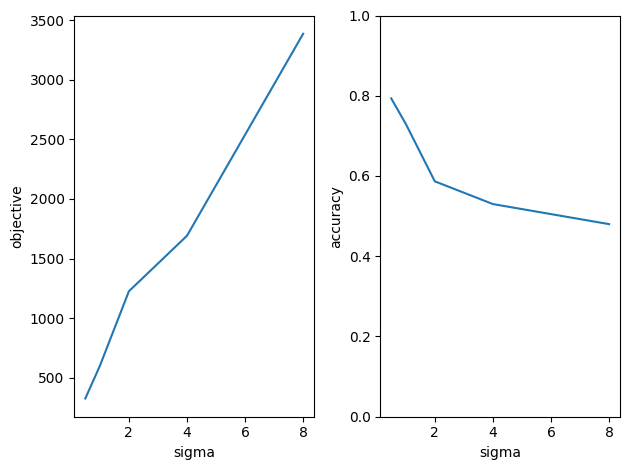

In [68]:
obj_, acc_ = [], []
for sigma in [0.5, 1, 2, 4, 8]:
    X, y = syn_data(sigma)
    centers_init = np.array([[-1, -1], [1, -1], [0, 1]])
    c, obj, acc =  kmeans(X, y, centers_init)
    obj_.append(obj)
    acc_.append(acc)
    # print(kmeans(x, y, centers_init))
import matplotlib.pyplot as plt
fig, (ax0, ax1) = plt.subplots(1, 2)
fig.tight_layout()
ax0.plot([0.5, 1, 2, 4, 8], obj_)
ax1.plot([0.5, 1, 2, 4, 8], acc_)
ax1.set_ylim(0,1)
plt.setp(ax0, xlabel='sigma', ylabel='objective')
plt.setp(ax1, xlabel='sigma', ylabel='accuracy')
fig.set_tight_layout(True)
plt.savefig('kmeans.pdf')
plt.show()
# ax1.set_title('Sharing Y axis')

#### GMM

In [44]:
import numpy as np
from scipy.stats import multivariate_normal

class GMM():

    def __init__(self, k) -> None:
        self.k = k

    def prob(self, data):
        likelihood_x_on_z = np.zeros( (self.n, self.k) ) 
        for i in range(self.k):
            distribution = multivariate_normal(mean=self.mu[i], cov=self.sigma[i])
            likelihood_x_on_z[:,i] = distribution.pdf(data) 

        joint_x_z = likelihood_x_on_z * self.phi
        prior_x = joint_x_z.sum(axis=1)[:, None]
        posterior_z_on_x = joint_x_z / prior_x
        return posterior_z_on_x, joint_x_z

    def estep(self, data):

        self.weights, _ = self.prob(data)
        self.phi = self.weights.mean(axis=0)

    def mstep(self, data):
        
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()

            self.mu[i] = (data * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(data.T, aweights=(weight/total_weight).flatten(), bias=True)

    def optimize(self, data, iters):
        
        self.n, self.m = data.shape # n: number of exapmles; m: dims
        self.phi = np.full(self.k, 1/self.k)
        self.weights = np.full(shape=data.shape, fill_value=1/self.k)

        random_row = np.random.randint(0, self.n, self.k)
        self.mu = [data[row_index,:] for row_index in random_row]
        self.sigma = [np.cov(data.T) for _ in range(self.k)]

        for i in range(iters):
            self.estep(data)
            self.mstep(data)

    def predict(self, X):
        posterior_z_on_x, _ = self.prob(X)
        return np.argmax(posterior_z_on_x, axis=1)
        
    
    def evaluate(self, x, y):
        posterior_z_on_x, joint_x_z = self.prob(x)
        y_ = np.argmax(posterior_z_on_x, axis=1)
        # y_ = self.predict(x)
        acc = (y_ == y).sum() / len(y)
        obj = np.log(joint_x_z.sum(axis=1)).sum()
        return obj, acc



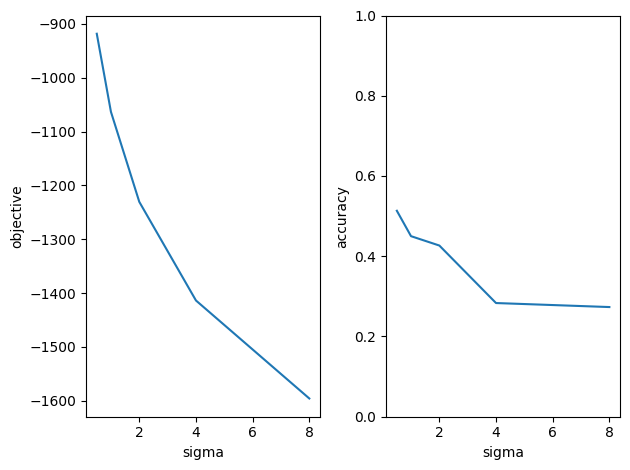

In [67]:
obj_, acc_ = [], []
for sigma in [0.5, 1, 2, 4, 8]:
    X, y = syn_data(sigma)
    gmm = GMM(k=3)
    gmm.optimize(X, iters=10)
    obj, acc = gmm.evaluate(X, y)
    obj_.append(obj)
    acc_.append(acc)
    
import matplotlib.pyplot as plt
fig, (ax0, ax1) = plt.subplots(1, 2)
fig.tight_layout()
ax0.plot([0.5, 1, 2, 4, 8], obj_)
ax1.plot([0.5, 1, 2, 4, 8], acc_)
ax1.set_ylim(0,1)
plt.setp(ax0, xlabel='sigma', ylabel='objective')
plt.setp(ax1, xlabel='sigma', ylabel='accuracy')
fig.set_tight_layout(True)
plt.savefig('gmm.pdf')
plt.show()

### Q2.3

In [1]:
import csv
import numpy as np

def load_csv(filename):

    f = open(filename)
    data_raw = csv.reader(f)
    data = np.array(list(data_raw), dtype=float)
    f.close()
    return data

data_2d = load_csv('data\data2D.csv')
data_1000d = load_csv('data\data1000D.csv')
print(data_2d.shape)
print(data_1000d.shape)


(50, 2)
(500, 1000)


### Buggy, Demeaned and Normalized PCA

In [70]:
from numpy.linalg import eig

class PCA():
    def __init__(self, d=1) -> None:
        self.d = d
        self.V = None
        self.mean = None
        self.std = None
        
    def fit(self, X, demean=False, normalize=False):
        
        if normalize:
            self.mean = np.mean(X, axis=0)
            self.std = np.std(X, axis=0)
            X = (X - self.mean) / self.std
            # print(np.mean(X, axis=0), np.std(X, axis=0))
        else:
            if demean:
                self.mean = np.mean(X, axis=0)
                X = X - self.mean

        S = X.T @ X
        eigenvalues, eigenvectors = eig(S)
        if eigenvalues.dtype == complex:
            eigenvalues = eigenvalues.real
        sorted_idx = np.argsort(eigenvalues)[::-1]
        sorted_eigenvectors = eigenvectors[:, sorted_idx]

        self.V = sorted_eigenvectors[:, :self.d]
    
    def dim_reduct(self, X):
        if self.std is not None:
            X = (X - self.mean) / self.std
        else:
            if self.mean is not None:
                X = X - self.mean
        Z = X @ self.V
        return Z
    
    def reconstruct(self, Z):

        X_ = Z @ self.V.T

        if self.std is not None:
            X_ = X_ * self.std + self.mean
        else:
            if self.mean is not None:
                X_ = X_ + self.mean

        return X_


### DRO

In [4]:
from numpy.linalg import svd

class DRO():
    def __init__(self, d=1) -> None:
        self.d = d
        self.A = None
        self.b = None
        
    def fit(self, X):

        # S = X.T @ X
        n, D = X.shape
        self.b = X.T @ np.ones((n, 1)) / n
        X_ = X - np.ones((n, n)) @ X / n

        U, S, V_T = svd(X_, full_matrices=False)
        sorted_idx = np.argsort(S)[::-1]
        sorted_S = S[sorted_idx]
        sorted_U = U[:, sorted_idx]
        sorted_V_T = V_T[sorted_idx]

        self.A = sorted_V_T[:self.d].T @ np.diag(sorted_S[:self.d]).T / np.sqrt(n)
        self.Z = np.sqrt(n) * sorted_U[:, :self.d]
    
    def dim_reduct(self, X):
        self.fit(X)
        return self.Z
    
    def reconstruct(self, Z):

        n = Z.shape[0]
        X_ = Z @ self.A.T + np.ones((n, 1)) @ self.b.T

        return X_


### On 2D dataset

In [71]:
X = data_2d
X_rec, errs = [], []

for demean, normalize in zip([False, True, True], [False, False, True]):
    pca = PCA(d=1)
    pca.fit(X, demean, normalize)
    Z = pca.dim_reduct(X)
    X_ = pca.reconstruct(Z)
    loss = np.linalg.norm(X-X_)**2
    X_rec.append(X_)
    errs.append(loss)
    # print(loss)

dro = DRO(d=1)
Z = dro.dim_reduct(X)
X_ = dro.reconstruct(Z)
loss = np.linalg.norm(X-X_)**2
X_rec.append(X_)
errs.append(loss)
# print(loss)

print(errs)

[44.34515418673971, 0.5003042814256459, 2.4736041727385345, 0.500304281425646]


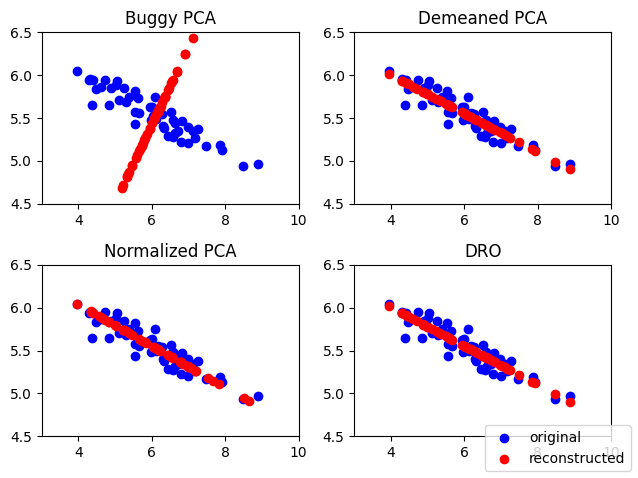

In [72]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2)

# axs[0,0] = plt.subplot(221)
ll = axs[0,0].scatter(X[:, 0], X[:, 1], c='b')
ll_ = axs[0,0].scatter(X_rec[0][:, 0], X_rec[0][:, 1], c='r')
axs[0,0].set_xlim(3, 10)
axs[0,0].set_ylim(4.5, 6.5)
axs[0,0].set_title('Buggy PCA')

# axs[0,1] = plt.subplot(222)
axs[0,1].scatter(X[:, 0], X[:, 1], c='b')
axs[0,1].scatter(X_rec[1][:, 0], X_rec[1][:, 1], c='r')
axs[0,1].set_xlim(3, 10)
axs[0,1].set_ylim(4.5, 6.5)
axs[0,1].set_title('Demeaned PCA')

# axs[1,0] = plt.subplot(223)
axs[1,0].scatter(X[:, 0], X[:, 1], c='b')
axs[1,0].scatter(X_rec[2][:, 0], X_rec[2][:, 1], c='r')
axs[1,0].set_xlim(3, 10)
axs[1,0].set_ylim(4.5, 6.5)
axs[1,0].set_title('Normalized PCA')


# axs[1,1] = plt.subplot(224)
axs[1,1].scatter(X[:, 0], X[:, 1], c='b')
axs[1,1].scatter(X_rec[3][:, 0], X_rec[3][:, 1], c='r')
axs[1,1].set_xlim(3, 10)
axs[1,1].set_ylim(4.5, 6.5)
axs[1,1].set_title('DRO')

# handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend((ll, ll_), ('original', 'reconstructed'), loc='lower right')
# plt.subplots_adjust(0,0,2,2)
fig.set_tight_layout(True)
plt.savefig('2d.pdf')
plt.show()

### On 1000D dataset

In [77]:
X = data_1000d
X_rec, errs = [], []
d = 500

for demean, normalize in zip([False, True, True], [False, False, True]):
    pca = PCA(d=d)
    pca.fit(X, demean, normalize)
    Z = pca.dim_reduct(X)
    X_ = pca.reconstruct(Z)
    loss = np.linalg.norm(X-X_)**2
    X_rec.append(X_)
    errs.append(loss)
    # print(loss)

dro = DRO(d=d)
Z = dro.dim_reduct(X)
X_ = dro.reconstruct(Z)
loss = np.linalg.norm(X-X_)**2
X_rec.append(X_)
errs.append(loss)
# print(loss)

print(errs)

[2.179062262799807e-14, 3.682196827896966e-18, 2.2078967128696577e-18, 1.288957569449717e-22]


We choose d=500, based on the observation that the singular values has a significant drop from the 500-th to the 501-th.